# Sports Dataset

10,000 random photos from soccer matches captured at a single timestamp make up the dataset. Every snapshot has a number of elements that offer details on the current match. The objective of the dataset is to capture the evolving dynamics of a soccer game, and to make predictions for the number of goals that will be scored for the remaining playing time.

# Dataset Structure

The dataset is presented in a single file with 10,000 rows and 20 columns, each row representing a snapshot of a soccer match, and each column representing a specific attribute or feature of that snapshot.

Number of Instances (Rows): 10,000 instances 
Number of Features (Columns): 20 features/columns 

# Feature Representation

The features include identifiers such as uuid, and dynamic match-related details such as the current minute of play, home and away team scores, yellow and red cards for both teams, the number of attacks and dangerous attacks by each team, corners awarded, shots on and off target for both teams, and the ball possession percentage for both the home and away teams until the current minute.

# Libraries

- pandas
- numpy
- matplotlib
- pickle
- os
- sklearn.metrics accuracy_score, classification_report, confusion_matrix
- sklearn.model_selection cross_val_predict, cross_val_score, train_test_split
- sklearn preprocessing 
- sklearn.linear_model LogisticRegression
- sklearn.model_selection GridSearchCV,train_test_split,RandomizedSearchCV
- sklearn.ensembke RandomForestClassifier

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = None
try:df = pd.read_csv(filepath_or_buffer = 'sports.csv', header = 0)
except:df = pd.read_csv(filepath_or_buffer = 'Dataset 3 - Sports Dataset/sports.csv', header = 0)
df

,uuid,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,...,away_dangerous_attacks,home_corners,away_corners,home_off_target,away_off_target,home_on_target,away_on_target,home_possession,away_possession,final_delta
0,2f9dd904-8d9d-4aa0-a9d9-4e0f3e50d742,94,1,2,0,0,0,0,39,45,...,26,4,1,4,0,4,6,48,52,1
1,869c1420-9153-4d73-8d79-5db31a8a80a4,91,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,50,50,1
2,549e25a3-4c93-459d-b115-fb303273c78a,3,0,0,0,0,0,0,3,1,...,0,0,0,0,0,0,0,62,38,4
3,287b4be5-9163-4e2e-895d-d11052a97410,17,0,0,1,0,0,0,41,46,...,25,1,0,0,2,0,0,55,45,2
4,a607da6a-d6b2-4652-b7a5-6c8e4b61c2b8,76,1,0,1,0,0,0,69,78,...,46,1,1,0,3,4,4,45,55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,838f35c5-afa3-474b-876e-063fd49d4326,32,0,0,0,0,0,0,16,25,...,13,0,1,1,2,0,1,45,55,0
6996,4bcfd248-5f39-4af2-b465-5358c9e7088e,101,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,50,50,0
6997,deccdc2c-625e-495a-9b06-02d540d4cd24,78,1,0,0,0,0,0,71,60,...,40,7,0,5,5,7,0,61,39,2
6998,94a20308-55d8-47cb-8f8b-d2702a531c74,72,2,0,0,0,0,0,85,66,...,20,3,0,4,1,2,1,52,48,0


# Goal
Our objective for this project is to use the data given in the dataset to predict whether 1 or more goals can be scored in the remaining playing time of the match.

# Data Preprocessing


Remove Missing Data

In [ ]:
df.dropna(inplace=True)

UUID is an unique identifier. no need to keep it.

In [ ]:
try:
    df = df.drop(['uuid'], axis=1)
except:
    print('no uuid')

Use only data taken within the game time. Games last 105 minutes.  
Then remove any data from halftime. Halftime should be around minute 45 to minute 60. Because of that, starting minute 60, subtract them by 15 to make data contiguous.

In [ ]:
df = df.query('0<= current_minute <= 105 ')
df = df.query('not (44 < current_minute <60)')
df['current_minute'] = df['current_minute'].apply(lambda x: x-15 if x > 45 else x)

<!-- df = df.groupby(df['current_minute'],as_index = False).aggregate('sum')
Aggregating was temptying but the samples became to small to use 
Feature Scaling
numerical_features = ['current_minute', 'home_score', 'away_score', 'home_yellow_cards', 'away_yellow_cards',
                      'home_red_cards', 'away_red_cards', 'home_attacks', 'away_attacks', 'home_dangerous_attacks',
                      'away_dangerous_attacks', 'home_corners', 'away_corners', 'home_off_target', 'away_off_target',
                      'home_on_target', 'away_on_target', 'home_possession', 'away_possession'] -->

In [ ]:
# the target variable indicates whether 1 goal or more will be scored with the remaining time of the match. it shows binary values
df['target']= 0
df.loc[df['home_score'] + df['away_score']>0,'target'] = 1

X = df.drop(['target','home_score','away_score'], axis=1)
y = df['target']


In [ ]:
# Current shape of our X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Exploratory Data Analysis

This is the content of the dataset

In [ ]:
print("First 5 rows of the dataset:")
df.head()

In [ ]:
df.plot(x='current_minute', y='target', style='o')
plt.xlabel('remaining_time')
plt.ylabel('target')
plt.show()

Basic summary statistics for numerical values.  
Chart above shows that some snapshots had goals. Others had none. The data given does not have enough resolution to resolve when goals were made.

In [ ]:
print("\nSummary statistics of numerical features:")
df.describe()

Scatterplot matrix for pairs of numerical features

In [ ]:
print("\nPairplot for numerical features:")
scatter_matrix = pd.plotting.scatter_matrix(df[['home_score', 'away_score', 'home_yellow_cards', 'away_yellow_cards', 'home_possession', 'away_possession']], figsize=(12, 8))
plt.show()

Histogram that shows the distribution of home and away scores

In [ ]:
print("\nDistribution of home and away scores:")
plt.figure(figsize=(12, 6))
plt.hist(df['home_score'], bins=20, alpha=0.5, label='Home Score', color='blue')
plt.hist(df['away_score'], bins=20, alpha=0.5, label='Away Score', color='red')
plt.title('Distribution of Home and Away Scores')
plt.legend()
plt.show()

# Data set splitting

In [ ]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale the data sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# split train data to test and validation sets equally
# train data will train the initial  model
# validation will be used to find the best hyper parameters
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Helpers
The cells below contain functions that will help with displaying things later

In [ ]:
# predictions: model predictions
# actual: the actual labels
#mode: type of data set evaluated
def show_metrics(true,predictions,mode = "Train"):
    
    accuracy = accuracy_score(true,predictions)
    conf_matrix = confusion_matrix(true,predictions)
    classification_rep = classification_report(true,predictions)
    
    print(f"\n{mode} Accuracy:", accuracy)
    print(f"{mode} Confusion Matrix:\n", conf_matrix)
    print(f"{mode} Classification Report:\n", classification_rep)
    return accuracy, conf_matrix,classification_rep

In [ ]:
def show_mat(mat,title = "Confusion Matrix"):
    fig, axes = plt.subplots(1, 1, figsize=(12, 4))
    
    # Confusion Matrix
    sns.heatmap(mat, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes)
    axes.set_xlabel('Predicted')
    axes.set_ylabel('True')
    axes.set_title(title)
    
    plt.show()

# Logistic Regression Model
Since this is a classification task, Logistic regression can be applied. Its implementation is rather simple here.

Step 1: Initialize and train the model

In [17]:
logreg = LogisticRegression(n_jobs = -1, max_iter = 10000)
logreg.fit(X_train_1,y_train_1)

LogisticRegression(max_iter=10000, n_jobs=-1)

Step 2: validate initial model


Train Accuracy: 0.8041825095057035
Train Confusion Matrix:
 [[263 112]
 [ 94 583]]
Train Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72       375
           1       0.84      0.86      0.85       677

    accuracy                           0.80      1052
   macro avg       0.79      0.78      0.78      1052
weighted avg       0.80      0.80      0.80      1052



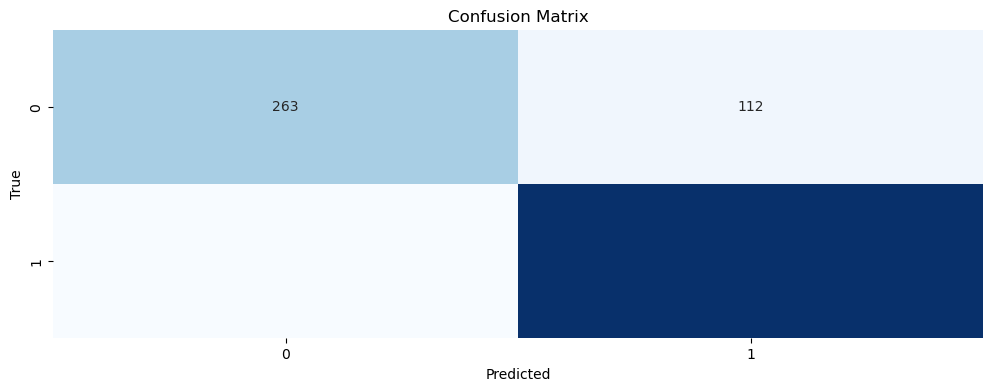

In [18]:
# This is the training 
metrics = show_metrics(y_train_1,logreg.predict(X_train_1))
show_mat(metrics[1])

Based on the class report, the model gives us approximately 80.42% accuracy of predictions for the train set. 

The confusion matrix gives us:
True Positives: 583
True Negatives: 263
False Positives: 112
False Negatives: 94

There is also a decent balance between the recall and precision for predicting whether one or more goals will be scored in the remaining time of a match.


Train Accuracy: 0.7963525835866262
Train Confusion Matrix:
 [[300 137]
 [131 748]]
Train Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.69      0.69       437
           1       0.85      0.85      0.85       879

    accuracy                           0.80      1316
   macro avg       0.77      0.77      0.77      1316
weighted avg       0.80      0.80      0.80      1316



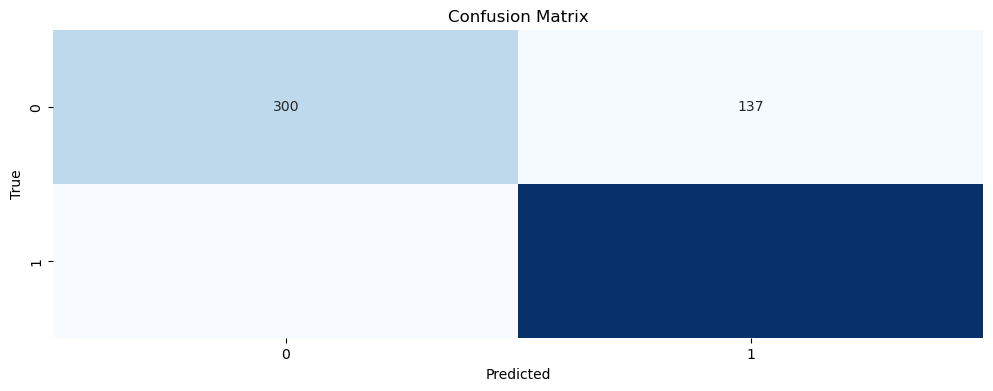

In [19]:
# get test accuracy with a validation set
test_pred = logreg.predict(X_test)
metrics = show_metrics(y_test,test_pred)
show_mat(metrics[1])


The accuracy on the validation set (79.64%) is slightly lower than the accuracy on the training set (80.42%). This model performed slightly lower on new, unseen data on the validation set. 

The confusion matrix gives us:
True Positives: 748
True Negatives: 300
False Positives: 137
False Negatives: 131

The confusion matrices show a similar pattern in terms of True Positives, True Negatives, False Positives, and False Negatives between the training and validation sets. Precision, recall, and F1-score for class (1) are also slightly consistent between the training and validation sets, indicating that the model's performance on predicting one or more goals is similar on both datasets.

Step 3: Find the best hyper parameters for the model

This is the grid of possible hyperparameter values to use. Dropped the solvers that use hessian matrix. Gridsearch practically did not finish. The regularization is only l2 because that is the only regularization function that all the solvers use. It is the default regularization. Regularization term C, tolerance, and the maximum iterations are only limited for demonstration purposes.

In [20]:
hpg = {'solver' : ['lbfgs', 'liblinear',  'sag','saga'],
      'fit_intercept' : [True,False],
       'class_weight' : [None, 'balanced'],
       # 'max_iter': [i for i in range(100,1000, 100)],
       'C' : [1.0,1.1,1.01,1.001,1.0001,1.00001],
       'tol' : [1e-5,1e-4,1e-3,1e-2,1e-1],
      }

Let the searching commence.

In [21]:
finder = GridSearchCV(logreg,hpg,n_jobs = -1,refit = True,scoring = 'f1',error_score='raise')

In [ ]:
finder.fit(X_val, y_val)

In [ ]:
finder.best_params_

In [24]:
logreg = finder.best_estimator_

To evaluate the model, we will get the training accuracy first. We used the validation set for training since the Training dataset was already used to train the initial model.


Train Accuracy: 0.7823711095272036
Train Confusion Matrix:
 [[ 989  504]
 [ 412 2304]]
Train Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.66      0.68      1493
           1       0.82      0.85      0.83      2716

    accuracy                           0.78      4209
   macro avg       0.76      0.76      0.76      4209
weighted avg       0.78      0.78      0.78      4209



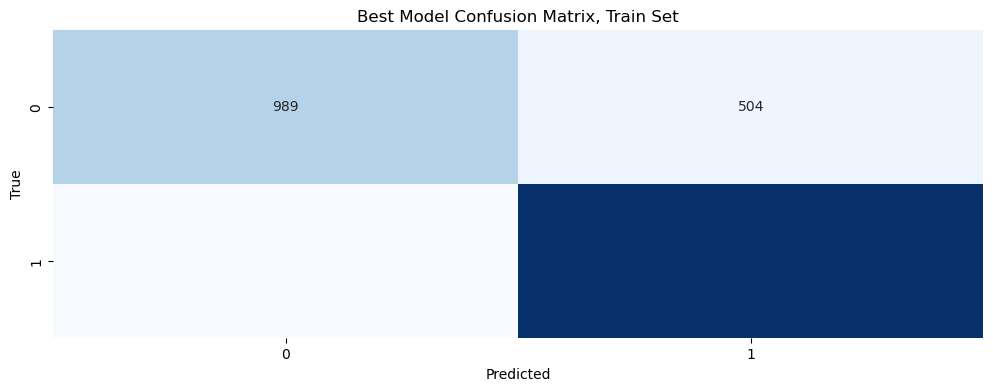

In [25]:
train_predictions = logreg.predict(X_val)
acc, mat, class_rep = show_metrics(y_val,train_predictions,"Train")
show_mat(mat,"Best Model Confusion Matrix, Train Set")

The accuracy slightly decreased after hyperparameter tuning, going from 80.42% to approximately 78%. This could be due to the model being more conservative after tuning.

There is a notable increase in both true positives (TP) and true negatives (TN) after hyperparameter tuning. However, false positives (FP) and false negatives (FN) have also increased.

The precision for class 1 remained the same, but recall and f1-score slightly decreased. This indicates that the model is still good at identifying instances of class 1, though there is still a chance that it does not capture some data points.

After evaluating the model on the validation set, we will now evaluate it on the test set to see how well it can predict on its own.

In [26]:
# Make predictions on the test setn
test_predictions = logreg.predict(X_test)


Train Accuracy: 0.7963525835866262
Train Confusion Matrix:
 [[301 136]
 [132 747]]
Train Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.69      0.69       437
           1       0.85      0.85      0.85       879

    accuracy                           0.80      1316
   macro avg       0.77      0.77      0.77      1316
weighted avg       0.80      0.80      0.80      1316



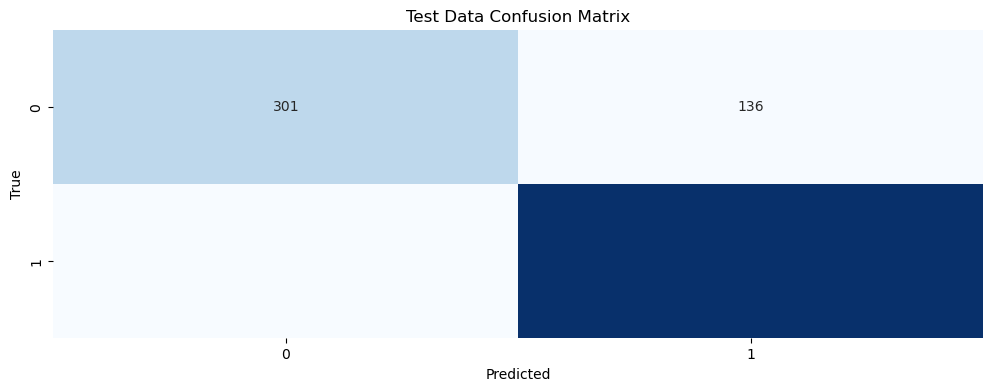

In [27]:
# Evaluate the model on the test set
metrics = show_metrics(y_test,test_predictions)
show_mat(metrics[1], "Test Data Confusion Matrix")

We can see that the accuracy on the test set (79.64%) is very close to the accuracy on the training set (78%). This suggests that the model is generalizing well to new, unseen data.

The true positives (TP) and true negatives (TN) on the test set are similar to those on the training set. False positives (FP) and false negatives (FN) also exhibit similar patterns.

The precision, recall, and f1-score for both classes (0 and 1) are consistent between the test and training sets. This indicates that the model's performance is stable across the two datasets.

# Logistic Regression Model Conclusions

After hyperparameter tuning, the test set performance is similar to the training set performance, suggesting that the model generalizes well to the test set. The hyperparameter-tuned model appears to be robust and not overfit to the training data based on the consistency of metrics between the training and test sets.

# Random Forest Classifier

In [ ]:
rfr = RandomForestaClassifier()
rfr.fit(X_train_1,y_train_1)